<a href="https://colab.research.google.com/github/seunghwan1228/TF-Torch/blob/main/RNN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# GPU 인스턴스 사용

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from dataclasses import dataclass

import os
import warnings

warnings.filterwarnings('ignore')

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

word_index = tf.keras.datasets.imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


In [42]:
idx2wor = {v:k for k, v in word_index.items()}

In [116]:
len(word_index)

88584

In [9]:
for n, (k, v) in enumerate(word_index.items()):
  print(k, ' -> ', v)
  if n == 3:
    break

fawn  ->  34701
tsukino  ->  52006
nunnery  ->  52007
sonja  ->  16816


-------------------------
## word_index 와 idx2wor 확인 해보세요


-------------------------

In [44]:
# word_index

In [47]:
# idx2wor

In [13]:
# Sample data

x_train[:5]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1

In [118]:
# Sequence max length 확인

def max_length(x):
  lengths = []
  for i in x:
    lengths.append(len(i))
  
  return max(lengths)

In [18]:
max_length(x_train)

2494

In [150]:
@dataclass
class Config:
  max_length = 500  # 학습 속도를 위해 sequence max lenght 를 500으로 고정

  # 아래 create sequence data 함수 확인 후 다시 config 설정
  padding_method = 'post'
  truncating_method = 'post'
  batch_size = 2048

  # Model Parameter
  num_words = len(word_index) + 1 # 왜 +1을 했을까요?  
  embedding_dim = 128
  
  rnn_units = 32



config = Config()

In [23]:
config.max_length # dataclass object 접근 방법

500

In [26]:
y_train[:5]

array([1, 0, 0, 1, 0])

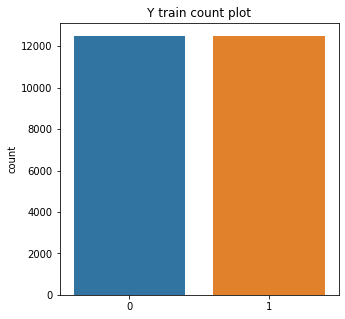

In [34]:
fig = plt.figure(figsize=(5, 5))
plt.title('Y train count plot')
sns.countplot(y_train)
plt.show()

```
데이터 로더 

Original Data loader 
  1) Tokenize
  2) padding
  3) batch



IMDB 데이터는 토큰화가 되어 있는 상태임으로 1번 생
```

공식 문서에서 어떤 메소드가 있는지 확인해 보세요


https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing

In [39]:
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=config.max_length, dtype='int32', padding='post', truncating='post') # padding data

In [41]:
x_train_pad[:5], x_train_pad[:5].shape

(array([[    1,    14,    22, ...,     0,     0,     0],
        [    1,   194,  1153, ...,     0,     0,     0],
        [    1,    14,    47, ...,     0,     0,     0],
        [    1,     4, 18609, ...,     7,     4,  9941],
        [    1,   249,  1323, ...,     0,     0,     0]], dtype=int32),
 (5, 500))

In [151]:
# tf.data Data Loader

def create_sequence_data(x, y, maxlen, padding_method, truncating_method, batch_size):

  x_padded = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=maxlen, padding=padding_method, truncating=truncating_method)
  
  ds = tf.data.Dataset.from_tensor_slices((x_padded, y))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds


In [152]:
train_ds = create_sequence_data(x_train, y_train, config.max_length, padding_method=config.padding_method, truncating_method=config.truncating_method, batch_size=config.batch_size)

valid_ds = create_sequence_data(x_test, y_test, config.max_length, padding_method=config.padding_method, truncating_method=config.truncating_method, batch_size=config.batch_size)

In [153]:
train_ds, valid_ds

(<PrefetchDataset shapes: ((None, 500), (None,)), types: (tf.int32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 500), (None,)), types: (tf.int32, tf.int64)>)

In [154]:
for sample_seq, sample_target in train_ds.take(1):
  pass


print(sample_seq)
print(sample_target)

tf.Tensor(
[[   1   14   22 ...    0    0    0]
 [   1  194 1153 ...    0    0    0]
 [   1   14   47 ...    0    0    0]
 ...
 [   1   51   70 ...    0    0    0]
 [   1   14   16 ...    0    0    0]
 [   1   75 4662 ...    0    0    0]], shape=(2048, 500), dtype=int32)
tf.Tensor([1 0 0 ... 1 1 0], shape=(2048,), dtype=int64)


-------------------------


### Tutorial Models

1. vanilla RNN

2. LSTN
  - Directional
  - Bidirectional

3. GRU
  - Directional
  - Bidirectional (생략)

4. Stacked LSTM

5. CNN

6. Hybrid (LSTM & CNN)




Task Description


IMDB는 영화 리뷰에 대한 데이터 입니다.

영화 리뷰를 바탕으로 이 리뷰의 뜻이 긍정인지 부정인지를 판단 하는 모델입니다.

In [91]:
positive_idx = tf.where(sample_target == 1).numpy().reshape(-1)

In [89]:
negative_idx = tf.where(sample_target == 0).numpy().reshape(-1)

In [92]:
positive_idx

array([  0,   3,   6,   8,  10,  16,  17,  19,  22,  24,  25,  28,  31,
        32,  33,  37,  40,  44,  45,  46,  48,  56,  58,  59,  63,  64,
        65,  66,  67,  68,  69,  70,  73,  74,  76,  79,  80,  83,  84,
        88,  97,  98, 104, 108, 109, 111, 113, 116, 118, 119, 120, 122,
       123, 124, 139, 140, 142, 143, 144, 145, 147, 148, 149, 150, 151,
       154, 155, 162, 163, 165, 167, 170, 171, 172, 174, 175, 177, 178,
       179, 180, 185, 187, 195, 196, 197, 200, 203, 207, 210, 211, 213,
       215, 216, 217, 218, 221, 223, 225, 226, 228, 229, 232, 233, 234,
       235, 236, 237, 238, 241, 243, 244, 245, 247, 248, 252, 254, 255,
       256, 257, 258, 261, 262, 264, 265, 268, 269, 270, 271, 272, 274,
       275, 277, 278, 279, 280, 283, 285, 286, 289, 294, 299, 300, 302,
       305, 307, 308, 309, 314, 315, 316, 317, 319, 320, 321, 323, 324,
       326, 329, 330, 331, 332, 334, 335, 336, 338, 339, 341, 344, 345,
       346, 347, 348, 349, 357, 358, 361, 362, 364, 366, 367, 36

In [94]:
# Data review

# Positive
print('Positive Example')
print(sample_seq[73][:200], sample_target[73])

print(('=').center(80, '=') + '\n')

# Negative

print('Negative Example')
print(sample_seq[1][:200], sample_target[1])

Positive Example
tf.Tensor(
[    1   480   302    18     6    20     7    14    58     6 21574     7
     4 30576     7   325     5    89   325   461     6 68128     7   410
    10    10     6   389   155    44    14    20     9    12     9   150
  1071 11727     5  1439    33  9360 14878    57  2909    57  1913    56
  1670   106    12    11    31  1266     5    25    80    30 16149    10
    10    13  1347     8  1497    14   509    19    17   111    84    17
   614    17    13    69   115   557     7    12   159     5    13   244
     6   254  2026   920   924   337    10    10    13    62    40     8
    67    89   409  4027     8    14    20    10    10   106    12    10
    10   967    12    10    10   376   178    51    25   104     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     

In [99]:
type(sample_seq[1][:200].numpy())

numpy.ndarray

In [114]:
def reverse_token(seq):
  res = []
  for s in seq:
    if s != 0:
      word = idx2wor[s]
      res.append(word)
  return ' '.join(res)


## 파파고... 고

In [115]:
reverse_token(sample_seq[1].numpy())

"the thought solid thought senator do making to is spot nomination assumed while he of jack in where picked as getting on was did hands fact characters to always life thrillers not as me can't in at are br of sure your way of little it strongly random to view of love it so principles of guy it used producer of where it of here icon film of outside to don't all unique some like of direction it if out her imagination below keep of queen he diverse to makes this stretch stefan of solid it thought begins br senator machinations budget worthwhile though ok brokedown awaiting for ever better were lugia diverse for budget look kicked any to of making it out bosworth's follows for effects show to show cast this family us scenes more it severe making senator to levant's finds tv tend to of emerged these thing wants but fuher an beckinsale cult as it is video do you david see scenery it in few those are of ship for with of wild to one is very work dark they don't do dvd with those them"

Experiment utilities


빠른 실험을 위해 저는 epochs를 `5` 만 주겠습니다

In [167]:
def start_experiment(model, epoch, train_ds, test_ds):
  # Compile model
  print(model.summary())
  
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(), 
                        metrics=[tf.keras.metrics.BinaryAccuracy()])

  hist = model.fit(train_ds, epochs=epoch, validation_data=valid_ds)
  print(model.evaluate(test_ds))

  hist_df = pd.DataFrame(hist.history)
  
  plt.figure()
  hist_df.plot()
  plt.show()
  return hist_df

Vanilla RNN



In [165]:
def vanilla_rnn(config):
  input_ = tf.keras.layers.Input(shape=(config.max_length, ), dtype=tf.int32)
  x = tf.keras.layers.Embedding(input_dim = config.num_words, output_dim=config.embedding_dim, mask_zero=True)(input_)

  x = tf.keras.layers.SimpleRNN(config.rnn_units)(x)

  x = tf.keras.layers.Dense(32)(x)
  output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.models.Model(input_, output_)
  return model

In [166]:
# Initialize Model

# GPU Mermory Release
tf.keras.backend.clear_session()
vanilla_rnn = vanilla_rnn(config)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 128)          11338880  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                5152      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 11,345,121
Trainable params: 11,345,121
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
13/13 [==============================] - 19s 1s/step - loss: 0.6910 - binary_accuracy: 0.5268 - val_

<Figure size 432x288 with 0 Axes>

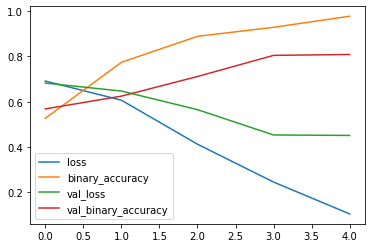

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.691012,0.52676,0.682069,0.56812
1,0.606615,0.77356,0.646900,0.62448
2,0.412543,0.88816,0.564981,0.71100
3,0.245604,0.92796,0.453217,0.80424
4,0.105157,0.97676,0.451195,0.80816


In [168]:
start_experiment(vanilla_rnn, 5, train_ds, valid_ds)

LSTM

In [169]:
def lstm_model(config):
  input_ = tf.keras.layers.Input(shape=(config.max_length, ), dtype=tf.int32)
  x = tf.keras.layers.Embedding(input_dim = config.num_words, output_dim=config.embedding_dim, mask_zero=True)(input_)

  x = tf.keras.layers.LSTM(config.rnn_units)(x)

  x = tf.keras.layers.Dense(32)(x)
  output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.models.Model(input_, output_)
  return model

In [170]:
tf.keras.backend.clear_session()
model = lstm_model(config)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 128)          11338880  
_________________________________________________________________
lstm (LSTM)                  (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 11,360,577
Trainable params: 11,360,577
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
13/13 [==============================] - 12s 516ms/step - loss: 0.6875 - binary_accuracy: 0.5809 - v

<Figure size 432x288 with 0 Axes>

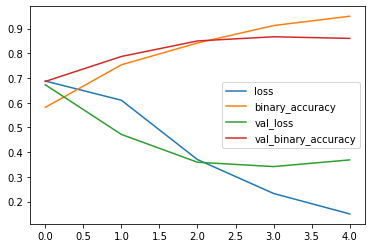

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.687469,0.58092,0.672488,0.68596
1,0.609825,0.75320,0.471457,0.78688
2,0.369667,0.84156,0.358915,0.84980
3,0.232520,0.91204,0.341352,0.86664
4,0.149768,0.94972,0.368350,0.86008


In [171]:
start_experiment(model, 5, train_ds, valid_ds)

Bidirectional

In [173]:
def bi_lstm_model(config):
  input_ = tf.keras.layers.Input(shape=(config.max_length, ), dtype=tf.int32)
  x = tf.keras.layers.Embedding(input_dim = config.num_words, output_dim=config.embedding_dim, mask_zero=True)(input_)

  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)

  x = tf.keras.layers.Dense(32)(x)
  output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.models.Model(input_, output_)
  return model

In [176]:
tf.keras.backend.clear_session()
model = bi_lstm_model(config)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 128)          11338880  
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 11,382,209
Trainable params: 11,382,209
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
13/13 [==============================] - 22s 1s/step - loss: 0.6840 - binary_accuracy: 0.6128 - val_

<Figure size 432x288 with 0 Axes>

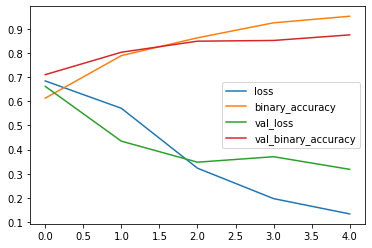

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.684012,0.61284,0.661391,0.71004
1,0.570847,0.78872,0.434947,0.80264
2,0.323248,0.86228,0.348075,0.84832
3,0.197485,0.92428,0.370699,0.85132
4,0.134226,0.95144,0.318540,0.87440


In [177]:
start_experiment(model, 5, train_ds, valid_ds)

GRU

In [178]:
def gru_model(config):
  input_ = tf.keras.layers.Input(shape=(config.max_length, ), dtype=tf.int32)
  x = tf.keras.layers.Embedding(input_dim = config.num_words, output_dim=config.embedding_dim, mask_zero=True)(input_)

  x = tf.keras.layers.GRU(config.rnn_units)(x)

  x = tf.keras.layers.Dense(32)(x)
  output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.models.Model(input_, output_)
  return model

In [179]:
tf.keras.backend.clear_session()
model = gru_model(config)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 128)          11338880  
_________________________________________________________________
gru (GRU)                    (None, 32)                15552     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 11,355,521
Trainable params: 11,355,521
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
13/13 [==============================] - 11s 517ms/step - loss: 0.6878 - binary_accuracy: 0.5664 - v

<Figure size 432x288 with 0 Axes>

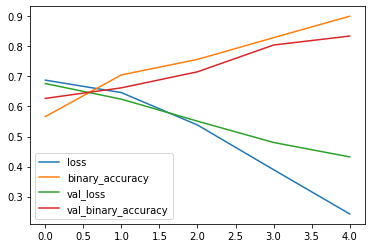

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.687801,0.56636,0.676333,0.62692
1,0.646219,0.70524,0.624330,0.66208
2,0.538372,0.75680,0.551115,0.71548
3,0.389523,0.82924,0.480143,0.80472
4,0.242171,0.90056,0.432080,0.83456


In [180]:
start_experiment(model, 5, train_ds, valid_ds)

Stacked LSTM or GRU

In [183]:
def stacked_model(config):
  input_ = tf.keras.layers.Input(shape=(config.max_length, ), dtype=tf.int32)
  x = tf.keras.layers.Embedding(input_dim = config.num_words, output_dim=config.embedding_dim, mask_zero=True)(input_)

  x = tf.keras.layers.LSTM(config.rnn_units, return_sequences=True)(x)
  x = tf.keras.layers.LSTM(config.rnn_units, return_sequences=True)(x)
  x = tf.keras.layers.LSTM(config.rnn_units)(x)

  x = tf.keras.layers.Dense(32)(x)
  output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.models.Model(input_, output_)
  return model

In [184]:
tf.keras.backend.clear_session()
model = stacked_model(config)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 128)          11338880  
_________________________________________________________________
lstm (LSTM)                  (None, 500, 32)           20608     
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 32)           8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33    

<Figure size 432x288 with 0 Axes>

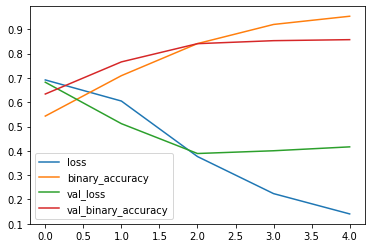

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.691469,0.54288,0.681950,0.63356
1,0.604691,0.70900,0.511679,0.76560
2,0.376476,0.84088,0.388951,0.84056
3,0.224074,0.91956,0.400283,0.85288
4,0.140631,0.95328,0.416295,0.85700


In [185]:
start_experiment(model, 5, train_ds, valid_ds)

CNN


RNN은 인풋의 순서를 State를 통해 전파되는데, CNN의 방식은 어떤방식으로 작동될까요?


In [186]:
def cnn_model(config):
  input_ = tf.keras.layers.Input(shape=(config.max_length, ), dtype=tf.int32)
  x = tf.keras.layers.Embedding(input_dim = config.num_words, output_dim=config.embedding_dim, mask_zero=True)(input_)

  x = tf.keras.layers.Conv1D(config.rnn_units, kernel_size=7, strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool1D()(x)
  x = tf.keras.layers.Conv1D(config.rnn_units, kernel_size=3, strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool1D()(x)
  x = tf.keras.layers.Conv1D(config.rnn_units, kernel_size=3, strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.GlobalAveragePooling1D()(x)
  x = tf.keras.layers.Dense(32)(x)
  output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.models.Model(input_, output_)
  return model

In [187]:
tf.keras.backend.clear_session()
model = cnn_model(config)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 128)          11338880  
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 125, 32)           3104  

<Figure size 432x288 with 0 Axes>

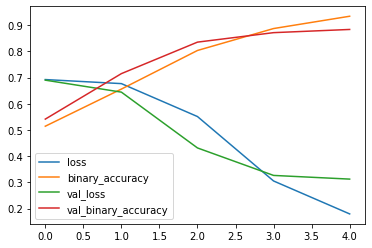

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.692529,0.51440,0.690267,0.54152
1,0.677049,0.65620,0.644521,0.71520
2,0.551296,0.80360,0.431456,0.83544
3,0.305327,0.88732,0.326538,0.87164
4,0.179547,0.93428,0.312452,0.88384


In [188]:
start_experiment(model, 5, train_ds, valid_ds)

Hybrid

In [189]:
def hybrid_model(config):
  input_ = tf.keras.layers.Input(shape=(config.max_length, ), dtype=tf.int32)
  x = tf.keras.layers.Embedding(input_dim = config.num_words, output_dim=config.embedding_dim, mask_zero=True)(input_)

  x = tf.keras.layers.Conv1D(config.rnn_units, kernel_size=7, strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool1D()(x)
  x = tf.keras.layers.Conv1D(config.rnn_units, kernel_size=3, strides=1, padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool1D()(x)

  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
  x = tf.keras.layers.Dense(32)(x)
  output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.models.Model(input_, output_)
  return model

In [190]:
tf.keras.backend.clear_session()
model = hybrid_model(config)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 128)          11338880  
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640 

<Figure size 432x288 with 0 Axes>

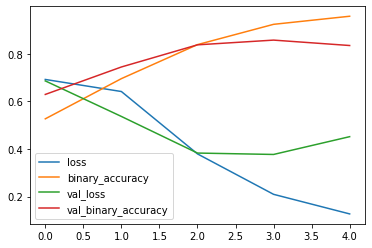

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.691733,0.52636,0.685668,0.62880
1,0.641057,0.69516,0.536359,0.74412
2,0.379049,0.83804,0.382547,0.83716
3,0.209212,0.92328,0.376696,0.85700
4,0.126929,0.95724,0.451412,0.83428


In [191]:
start_experiment(model, 5, train_ds, valid_ds)

Q: Simple RNN 은 파리미터가 LSTM에 비해 적은데 왜 학습 속도가 더 느린가요?

A: Tensorflow의 LSTM은 dropout을 적용하지 않으면 CUDNN-LSTM이라는 cuda 가속 lstm을 사용합니다. 물론 rnn도 학습시 gpu를 사용하지만, cudnn-lstm은 cuda에서의 학습 속도를 개선시킨 레이어입니다.

-----------------------------

Q: CNN은 어떤 역활을 하는 건가요?

A: CNN알고리즘은 kernel_size를 통해서 시퀸스를 하나의 윈도우로 묶고, 이에 대한 convolution 알고리즘을 사용합니다, 따라서 해당 윈도우의 정보를 그룹화 하는 역활과 N-gram의 역활을 함께 할수 있습니다.

N-Gram??

https://wikidocs.net/21692


-----------------------------

Q: Config의 num_words에 +1은 무슨 의미 인가요?

A: Config에 num_words에 +1 을 한 이유는, 바로 padding-token인 0 이 우리 데이터 상에 있기 때문입니다


-----------------------------

Q: Embedding 레이어의 mask_zero는 어떤 의미인가요?

A: 현재 구성된 데이터는 0이라는 패딩 value가 있는데, 모델 학습시 value=0에 대한 mask를 통해 무시하게 하는 효과가 있습니다





-------------------------------------------


## Config와 다양한 모델을 테스트 해보세요